In [ ]:
# Requirements for training Environment
# The training is done on Google Colab notebook using T4 hosted runtime environment
!pip freeze

absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.3
aiohttp==3.11.2
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.6
astropy-iers-data==0.2024.11.18.0.35.2
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.27.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.1
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.

In [ ]:
!python -V

Python 3.10.12


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, UpSampling2D,Dropout
from keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select digits
selected_digits = [3,5,8]
# Ensure the mask dimensions match the dataset labels
train_mask = np.isin(y_train, selected_digits)  # Boolean mask for training labels
test_mask = np.isin(y_test, selected_digits)    # Boolean mask for test labels

# Debug: Check mask and data dimensions
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, train_mask shape: {train_mask.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}, test_mask shape: {test_mask.shape}")

# Apply the mask to filter the dataset
x_train_filtered = x_train[train_mask]  # Select rows where train_mask is True
y_train_filtered = y_train[train_mask]
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

# Verify the filtered dataset shapes
print(f"x_train_filtered shape: {x_train_filtered.shape}")
print(f"y_train_filtered shape: {y_train_filtered.shape}")
print(f"x_test_filtered shape: {x_test_filtered.shape}")
print(f"y_test_filtered shape: {y_test_filtered.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28), y_train shape: (60000,), train_mask shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,), test_mask shape: (10000,)
x_train_filtered shape: (17403, 28, 28)
y_train_filtered shape: (17403,)
x_test_filtered shape: (2876, 28, 28)
y_test_filtered shape: (2876,)


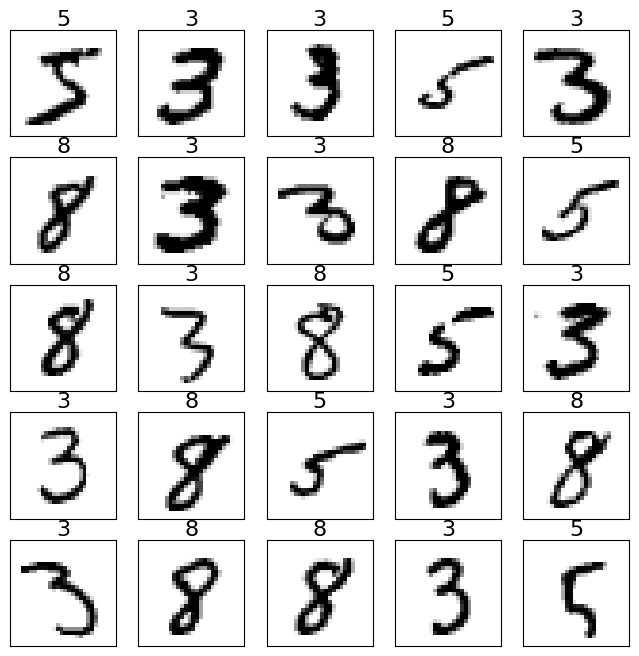

In [ ]:
plt.figure(figsize = (8,8))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.title(str(y_train_filtered[i]),fontsize = 16, color = 'black', pad = 2)
  plt.imshow(x_train_filtered[i], cmap = plt.cm.binary )
  plt.xticks([])
  plt.yticks([])

plt.show()

In [ ]:
#Splitting validation and Testing data
val_images = x_test_filtered[:1438]
test_images = x_test_filtered[1438:]

In [ ]:
val_images = val_images.astype('float32') / 255.0
val_images = np.reshape(val_images,(val_images.shape[0],28,28,1))

test_images = test_images.astype('float32') / 255.0
test_images = np.reshape(test_images,(test_images.shape[0],28,28,1))

train_images = x_train_filtered.astype("float32") / 255.0
train_images = np.reshape(train_images, (train_images.shape[0],28,28,1))

In [ ]:
# Adding noise to the images
factor = 0.39
train_noisy_images = train_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = train_images.shape)
val_noisy_images = val_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = val_images.shape)
test_noisy_images = test_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = test_images.shape)

# here maximum pixel value for our images may exceed 1 so we have to clip the images
train_noisy_images = np.clip(train_noisy_images,0.,1.)
val_noisy_images = np.clip(val_noisy_images,0.,1.)
test_noisy_images = np.clip(test_noisy_images,0.,1.)


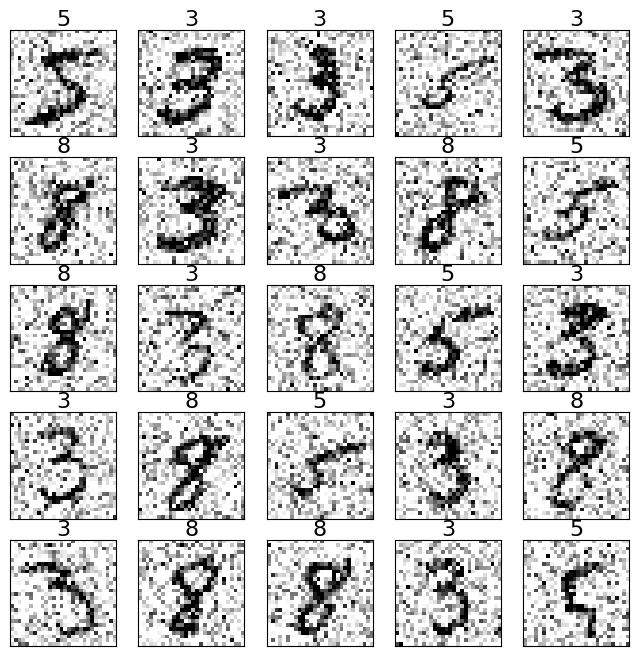

In [ ]:
plt.figure(figsize = (8,8))

for i in range(25):
      plt.subplot(5,5,i+1)
      plt.title(str(y_train_filtered[i]),fontsize = 16, color = 'black', pad = 2)
      plt.imshow(train_noisy_images[i].reshape(1,28,28)[0], cmap = plt.cm.binary )
      plt.xticks([])
      plt.yticks([])

plt.show()

In [ ]:
model = Sequential()
# encoder network
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same', input_shape = (28,28,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2),strides = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (2,2),strides = (2,2), activation = 'relu', padding = 'same'))



# decoder network
model.add(Conv2D(filters = 512, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.Conv2DTranspose(filters = 512, kernel_size = (2,2), strides = (2,2),activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (2,2),strides = (2,2), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 1, kernel_size = (2,2), activation = 'relu', padding = 'same'))


# to get the summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 128)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 512)           │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 512)         │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 512)         │           2,0

 Total params: 9,292,993 (35.45 MB)

 Trainable params: 9,285,953 (35.42 MB)

 Non-trainable params: 7,040 (27.50 KB)

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 15.3 MB/s eta 0:00:00


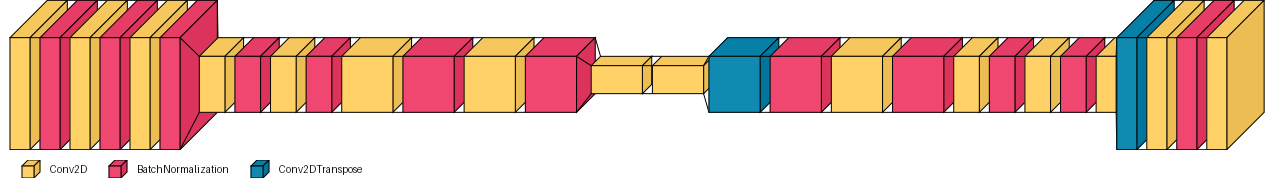

In [ ]:
import visualkeras
# Generate the layered view of the model
visualkeras.layered_view(model, legend=True)

In [ ]:
OPTIMIZER =  tf.keras.optimizers.Adam(learning_rate = 0.001)
LOSS = 'mean_squared_error'
model.compile(optimizer =OPTIMIZER, loss = LOSS, metrics = ['accuracy'])

In [ ]:
EPOCHS = 14
BATCH_SIZE = 256
VALIDATION = (val_noisy_images, val_images)
history = model.fit(train_noisy_images, train_images,batch_size = BATCH_SIZE,epochs = EPOCHS, validation_data = VALIDATION)

Epoch 1/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 59s 675ms/step - accuracy: 0.7181 - loss: 0.2562 - val_accuracy: 0.8003 - val_loss: 0.1094
Epoch 2/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 541ms/step - accuracy: 0.7901 - loss: 0.0271 - val_accuracy: 0.8003 - val_loss: 0.1115
Epoch 3/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 555ms/step - accuracy: 0.7972 - loss: 0.0120 - val_accuracy: 0.8003 - val_loss: 0.1116
Epoch 4/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 564ms/step - accuracy: 0.7974 - loss: 0.0104 - val_accuracy: 0.8003 - val_loss: 0.1116
Epoch 5/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 552ms/step - accuracy: 0.7973 - loss: 0.0097 - val_accuracy: 0.8004 - val_loss: 0.1077
Epoch 6/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 559ms/step - accuracy: 0.7973 - loss: 0.0091 - val_accuracy: 0.8016 - val_loss: 0.0774
Epoch 7/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.7981 - loss: 0.0089 - val_accuracy: 0.8038 - val_loss: 0.0446
Epoch 8/14
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 562ms/step - accuracy: 0.7985 - loss: 0.0086 - val_accu

In [ ]:
# To connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

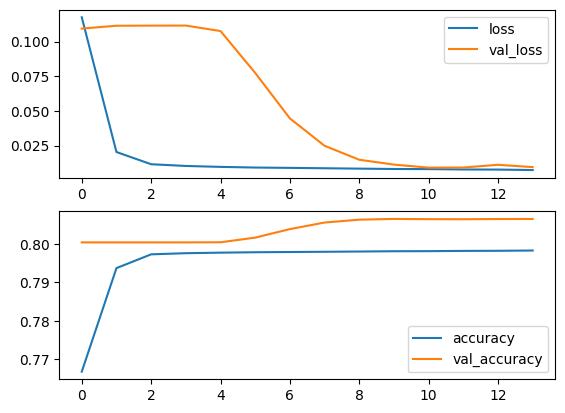

In [ ]:
plt.subplot(2,1,1)
plt.plot( history.history['loss'], label = 'loss')
plt.plot( history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.plot( history.history['accuracy'], label = 'accuracy')
plt.plot( history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'best')
plt.show()

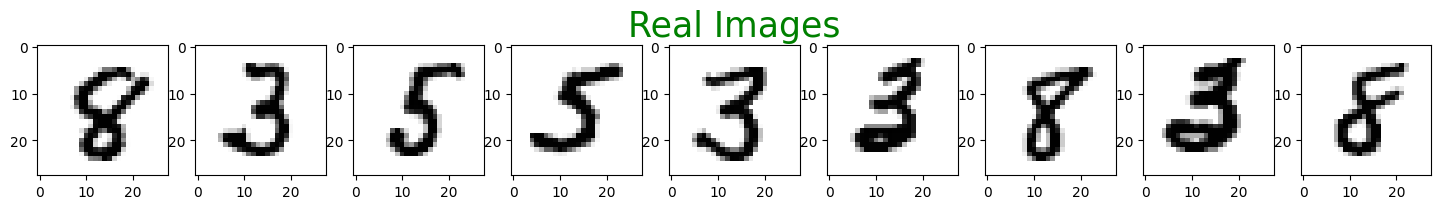

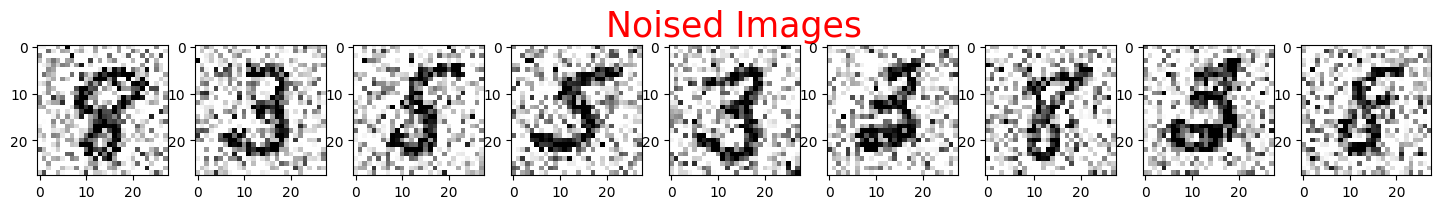

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


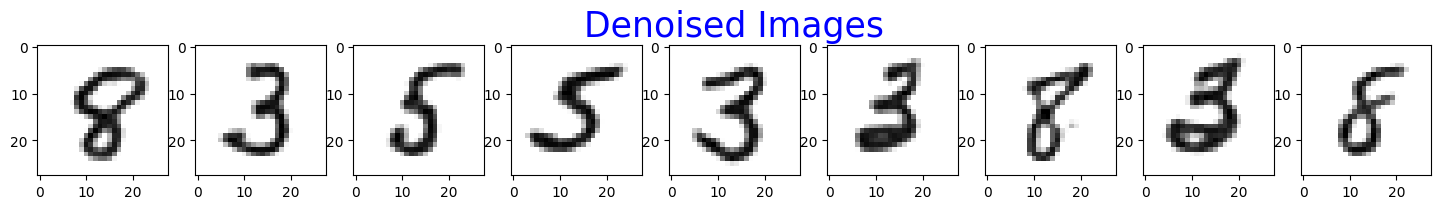

In [ ]:
plt.figure(figsize = (18,18))
for i in range(10,19):
    plt.subplot(9,9,i)
    if(i == 14):
        plt.title('Real Images', fontsize = 25, color = 'Green')
    plt.imshow(test_images[i].reshape(1,28,28)[0], cmap = plt.cm.binary)
plt.show()


plt.figure(figsize = (18,18))
for i in range(10,19):
    if(i == 15):
        plt.title('Noised Images', fontsize = 25, color = 'red')
    plt.subplot(9,9,i)
    plt.imshow(test_noisy_images[i].reshape(1,28,28)[0], cmap = plt.cm.binary)
plt.show()


plt.figure(figsize = (18,18))
for i in range(10,19):
    if(i == 15):
        plt.title('Denoised Images', fontsize = 25, color = 'Blue')

    plt.subplot(9,9,i)
    plt.imshow(model.predict(test_noisy_images[i].reshape(1,28,28,1)).reshape(1,28,28)[0], cmap = plt.cm.binary)
plt.show()

In [ ]:
# Evaluate the model on the test data
training_mse, training_accuracy = model.evaluate(train_noisy_images, train_images, verbose=0)
testing_mse, testing_accuracy = model.evaluate(test_noisy_images, test_images, verbose=0)

print(f"Training MSE Loss: {training_mse:.4f}")
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Testing MSE Loss: {testing_mse:.4f}")
print(f"Testing Accuracy: {testing_accuracy:.4f}")

Training MSE Loss: 0.0081
Training Accuracy: 0.7985
Testing MSE Loss: 0.0094
Testing Accuracy: 0.7869


In [ ]:
import pickle

# Save the trained model as a pickle string.
path = "/content/gdrive/MyDrive/EEE 511/"
filename = path + 'final_autoencoder_model.sav'
pickle.dump(model, open(filename, 'wb'))